In [1]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [35]:
db = DB('earthfury-alliance', timerange=21)

In [36]:
item = 2840 # copper bar

### Percentile Functions

In [37]:
def pctBelowValue(series, value):
    return stats.percentileofscore(series, value)/100

def pctAboveValue(series, value):
    return 1-stats.percentileofscore(series, value)/100

def valueAtPctile(series, pctile):
    return series.quantile(pctile)
    

### Daily Rollups

In [38]:
def dailyMax(item, column='minBuyout'):
    # use pctile instead of max() to avoid outliers, and tweak demand assumptions
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.7)

def dailyMin(item, column='minBuyout'):
    # use 10 pctile instead of min() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.1)

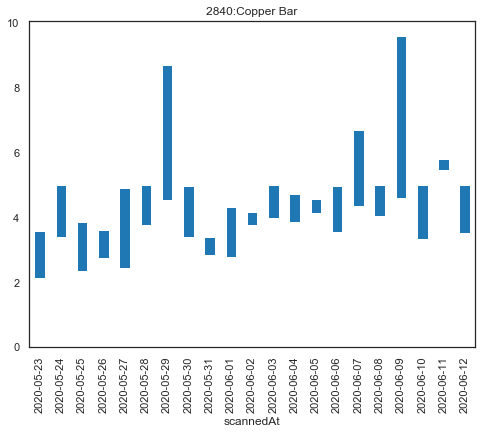

In [39]:
def plotDailyRange(item, buyAt=None, sellAt=None):
    title = f'{item}:{db.get_name(item)}'
        
    # create bars
    _, ax = plt.subplots()
    dailyMax(item).plot(kind='bar', x='scannedAt', y='minBuyout', title=title, ax=ax)
    dailyMin(item).plot(kind='bar', x='scannedAt', y='minBuyout', color='w', ax=ax)
    
    # add buy lines if passed
    if buyAt and sellAt:
        ax.axhline(y=buyAt, color='red')
        ax.axhline(y=sellAt, color='green')

    
plotDailyRange(item)

### Analysis

In [40]:
def postcost_at_salerate(item, salerate):
    if salerate == 0:
        return 0
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

def iterPrice(item):
    # iterate from min price to max price in .01 percentile steps
    for pctile in np.arange(0, 1, .01):
        yield db.get_df_hourly(item)['minBuyout'].quantile(pctile)

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi
12,16000,Thorium Tube,42.0,0.904762,2.368421,39.9,39.0,0.065606,-1.468421,0.059358,-0.087163,-0.002107
13,16000,Thorium Tube,42.0,0.904762,2.368421,39.9,39.0,0.065606,-1.468421,0.059358,-0.087163,-0.002107


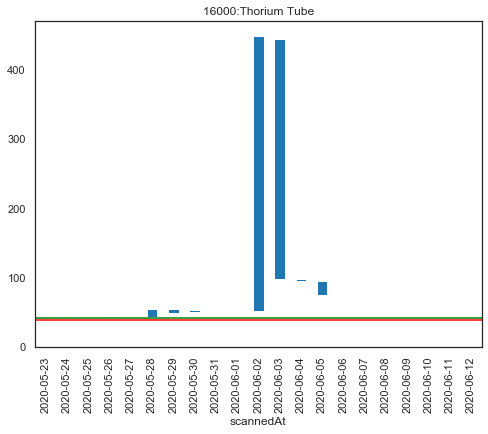

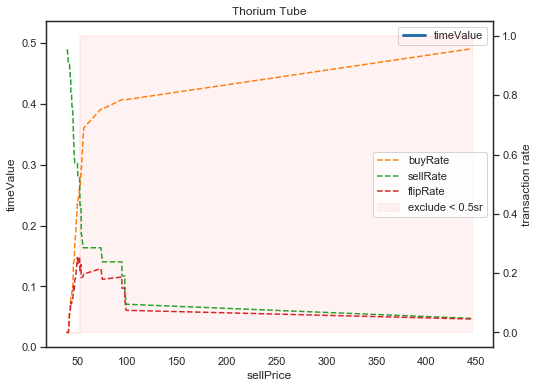

In [150]:
def analysis(item, show=False, minSellRate=.5):
    data = []
    for sellPrice in iterPrice(item):
        sellRate = pctAboveValue(dailyMax(item), sellPrice) # use dailyMax series due to selling pattern

        # expected posting cost based on avail sell
        postCost = postcost_at_salerate(item, sellRate)

        # buying values
        maxBuy   = sellPrice * .95
        meanBuy  = db.get_df_hourly(item).query('minBuyout <= @maxBuy')['minBuyout'].mean()
        buyRate  = pctBelowValue(db.get_df_hourly(item)['minBuyout'], maxBuy) # use hourly series due to buying pattern        

        # profit
        value = sellPrice*.95 - meanBuy - postCost
        timeValue = value * sellRate * buyRate
        roi = timeValue / (meanBuy + postCost)        
        
        # load into data
        data.append({
            'item_id'  :item,
            'name'     :db.get_name(item),
            'sellPrice':sellPrice,
            'sellRate' :sellRate, 
            'postCost' :postCost,
            'maxBuy'   :maxBuy, 
            'meanBuy'  :meanBuy,
            'buyRate'  :buyRate,
            'value'    :value, 
            'flipRate' :sellRate * buyRate,
            'timeValue':timeValue, 
            'roi'      :roi,        
        })

    # data frame for analysis
    df = pd.DataFrame(data)    
    best = df.loc[df['roi'] == df.query('sellRate > @minSellRate')['roi'].max()]
    if best.empty:
        # if no optimal found above cutoff, find best anyway
        best = df.loc[df['roi'] == df['roi'].max()]
    
    if show:
        # plot daily range and buy/sell lines
        display(best)
        plotDailyRange(item, best.iloc[0]['meanBuy'], best.iloc[0]['sellPrice'])
        
        # plot analysis curve
        _, ax = plt.subplots()
        df.plot(x='sellPrice', y=['timeValue'], title=db.get_name(item), linewidth=3, ax=ax)
        plt.plot(best['sellPrice'],best['timeValue'],'ro') 
        
        # create exclusion zone based on cutoff
        exclude_name = f'exclude < {minSellRate}sr'
        df[exclude_name] = df['sellRate'].apply(lambda x: x<minSellRate).astype(int)
        df.plot(kind='area', x='sellPrice', y=exclude_name, secondary_y=True, color='red', alpha=.05, ax=ax, legend=False)
        
        # plot roi and rates
        df.plot(x='sellPrice', y=['buyRate', 'sellRate', 'flipRate'], style='--', secondary_y=True, ax=ax, legend=False).legend(loc='center right')
        ax.set_ylabel('timeValue')
        ax.right_ax.set_ylabel('transaction rate')
        return
    return best.to_dict('r')[0]
    
analysis(16000, show=True)

### Full Run

In [98]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  eng         : 53 items
  ALL         : 228 items



In [102]:
%%time

# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(ALL, analysis)

running for 228 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
 ...110 done
 ...120 done
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
 ...180 done
 ...190 done
 ...200 done
 ...210 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...220 done
COMPLETE
Wall time: 3min 18s


### Augment Result with additional columns

In [103]:
df['quantity'] = df['item_id'].apply(lambda x : int(db.get_df(x)['quantity'].mean()))

# looking at std and stuff
# df['std']  = df['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].std())
# df['mean'] = df['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].mean())
# df['coefVar'] = df['std']/df['mean']
# df = df.round(2)

df.head()

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity
0,8153,Wildvine,119.99,0.52,0.03,113.99,102.86,0.43,17.10,0.22,3.82,0.04,136
1,8836,Arthas' Tears,4.75,0.90,0.06,4.51,3.73,0.25,0.96,0.23,0.22,0.06,104
2,13468,Black Lotus,14800.00,0.52,5.45,14060.00,12938.45,0.47,1856.10,0.25,459.01,0.04,21
3,13466,Plaguebloom,254.00,0.62,0.92,241.30,226.08,0.40,27.00,0.25,6.63,0.03,272
4,13465,Mountain Silversage,145.12,0.62,0.55,137.87,128.14,0.46,16.44,0.29,4.72,0.04,432


In [119]:
# set restock, based on 100x sungrass restock
scalar = df.query('name == "Sungrass"')['quantity'].iloc[0]
df['restock'] = (100 * df['quantity'] / scalar).astype(int)
df.head()

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock
0,8153,Wildvine,119.99,0.52,0.03,113.99,102.86,0.43,17.10,0.22,3.82,0.04,136,45
1,8836,Arthas' Tears,4.75,0.90,0.06,4.51,3.73,0.25,0.96,0.23,0.22,0.06,104,34
2,13468,Black Lotus,14800.00,0.52,5.45,14060.00,12938.45,0.47,1856.10,0.25,459.01,0.04,21,7
3,13466,Plaguebloom,254.00,0.62,0.92,241.30,226.08,0.40,27.00,0.25,6.63,0.03,272,91
4,13465,Mountain Silversage,145.12,0.62,0.55,137.87,128.14,0.46,16.44,0.29,4.72,0.04,432,144


### Create Choice

In [175]:
def filterMinQuantity(df, minQuantity=100, show=False):
    if show:
        removed = df.query('quantity < @minQuantity')
        print(f'Removing {len(removed)} of {len(df)} rows...')
        display(removed)
    return df.query('quantity >= @minQuantity')

#choice = df.copy()
_ = filterMinQuantity(df, minQuantity=100, show=True)

Removing 127 of 218 rows...


,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock,vendorPrice
2,13468,Black Lotus,14800.00,0.52,5.45,14060.00,12938.45,0.47,1856.10,0.25,459.01,0.04,21,7,10.00
9,3369,Grave Moss,44.43,0.57,0.11,42.21,37.93,0.49,6.39,0.28,1.77,0.05,93,31,0.25
21,3819,Wintersbite,112.31,0.67,0.30,106.70,100.34,0.42,11.67,0.28,3.30,0.03,97,32,1.00
35,14256,Felcloth,408.29,0.76,3.75,387.87,359.92,0.26,44.62,0.20,8.80,0.02,70,23,20.00
36,14342,Mooncloth,2149.58,0.57,18.00,2042.10,1972.97,0.36,158.62,0.21,32.86,0.02,27,9,40.00
37,2996,Bolt of Linen Cloth,1.93,0.57,0.18,1.83,0.96,0.55,0.79,0.32,0.25,0.22,67,22,0.40
38,2997,Bolt of Woolen Cloth,4.93,0.57,0.45,4.69,2.73,0.60,1.76,0.34,0.60,0.19,48,16,1.00
39,4305,Bolt of Silk Cloth,9.97,0.95,0.18,9.47,8.43,0.21,1.36,0.20,0.28,0.03,96,32,6.00
40,4339,Bolt of Mageweave,19.49,0.95,0.38,18.52,16.65,0.10,2.47,0.10,0.24,0.01,84,28,12.50
41,14048,Bolt of Runecloth,56.98,0.81,2.82,54.13,47.53,0.39,6.62,0.31,2.08,0.04,48,16,20.00


In [176]:
def filterMinPrice(df, minPrice=2, show=False):
    if show:
        removed = df.query('sellPrice < @minPrice')
        print(f'Removing {len(removed)} of {len(df)} rows...')
        display(removed)
    return df.query('sellPrice >= @minPrice')

_ = filterMinPrice(df, minPrice=2, show=True)        

Removing 20 of 218 rows...


,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock,vendorPrice
10,2447,Peacebloom,0.37,0.71,0.02,0.35,0.20,0.46,0.15,0.33,0.05,0.22,235,78,0.10
11,765,Silverleaf,0.28,0.62,0.04,0.27,0.16,0.57,0.08,0.35,0.03,0.14,317,106,0.10
24,2449,Earthroot,0.47,0.76,0.04,0.45,0.29,0.41,0.14,0.32,0.05,0.14,252,84,0.20
25,785,Mageroyal,0.23,0.86,0.02,0.22,0.19,0.26,0.02,0.22,0.00,0.02,305,102,0.20
29,13464,Golden Sansam,1.73,0.57,0.45,1.64,1.15,0.60,0.12,0.34,0.04,0.03,209,70,1.00
30,2589,Linen Cloth,0.56,0.76,0.02,0.53,0.36,0.53,0.17,0.41,0.07,0.18,938,314,0.13
31,4306,Silk Cloth,1.92,1.00,0.00,1.82,1.67,0.23,0.25,0.23,0.06,0.03,1950,654,1.50
33,2592,Wool Cloth,0.67,0.90,0.02,0.64,0.52,0.34,0.13,0.31,0.04,0.07,1525,511,0.33
37,2996,Bolt of Linen Cloth,1.93,0.57,0.18,1.83,0.96,0.55,0.79,0.32,0.25,0.22,67,22,0.40
47,5833,Indurium Ore,1.80,0.90,0.00,1.71,0.78,0.15,1.02,0.14,0.14,0.18,12,4,0.00


In [177]:
def filterVendorPrice(df, ratio=1.2, show=False):
    df['vendorPrice'] = df['item_id'].apply(db.get_vendorprice)
    if show:
        removed = df.query('sellPrice < @ratio * vendorPrice')
        print(f'Removing {len(removed)} of {len(df)} rows...')
        display(removed)
    return df.query('sellPrice >= @ratio * vendorPrice')    

_ = filterVendorPrice(df, ratio=1.2, show=True)

Removing 9 of 218 rows...


,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock,vendorPrice
25,785,Mageroyal,0.23,0.86,0.02,0.22,0.19,0.26,0.02,0.22,0.00,0.02,305,102,0.20
60,6037,Truesilver Bar,14.55,1.00,0.00,13.83,13.36,0.11,1.19,0.11,0.13,0.01,94,31,12.50
98,8169,Thick Hide,4.98,1.00,0.00,4.73,4.19,0.02,0.79,0.02,0.01,0.00,33,11,5.00
105,12203,Red Wolf Meat,0.97,0.90,0.05,0.92,0.86,0.20,0.05,0.18,0.01,0.01,58,19,0.87
168,16000,Thorium Tube,42.00,0.90,2.37,39.90,39.00,0.07,0.63,0.06,0.04,0.00,20,6,37.50
171,12804,Powerful Mojo,20.47,1.00,0.00,19.45,18.28,0.10,2.19,0.10,0.21,0.01,101,33,20.00
201,10286,Heart of the Wild,3.99,1.00,0.00,3.79,3.07,0.02,0.92,0.02,0.02,0.01,119,39,4.00
211,8150,Deeprock Salt,2.53,1.00,0.00,2.40,1.31,0.02,1.22,0.02,0.02,0.02,97,32,2.50
212,8151,Flask of Mojo,2.88,0.90,0.16,2.74,2.56,0.13,0.17,0.12,0.02,0.01,37,12,2.50


In [178]:
def filterMinSellRate(df, minSellRate=.5, show=False):
    if show:
        removed = df.query('sellRate < @minSellRate')
        print(f'Removing {len(removed)} of {len(df)} rows...')
        display(removed)
    return df.query('sellRate >= @minSellRate')    

_ = filterMinSellRate(df, minSellRate=.5, show=True)

Removing 1 of 218 rows...


,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock,vendorPrice
153,16040,Arcane Bomb,7530.3,0.22,84.0,7153.78,3211.2,0.81,4235.1,0.18,759.64,0.23,3,1,40.0


In [205]:
choice = df.copy()
choice = filterMinQuantity(choice, minQuantity=100)
choice = filterVendorPrice(choice, ratio=1.2)
choice = filterMinPrice(choice, minPrice=2)
choice = filterMinSellRate(choice, minSellRate=.5)
choice

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,flipRate,timeValue,roi,quantity,restock,vendorPrice
0,8153,Wildvine,119.99,0.52,0.03,113.99,102.86,0.43,17.10,0.22,3.82,0.04,136,45,0.05
1,8836,Arthas' Tears,4.75,0.90,0.06,4.51,3.73,0.25,0.96,0.23,0.22,0.06,104,34,0.95
3,13466,Plaguebloom,254.00,0.62,0.92,241.30,226.08,0.40,27.00,0.25,6.63,0.03,272,91,2.50
4,13465,Mountain Silversage,145.12,0.62,0.55,137.87,128.14,0.46,16.44,0.29,4.72,0.04,432,144,1.50
5,8845,Ghost Mushroom,109.99,0.57,1.69,104.49,101.48,0.30,6.82,0.17,1.19,0.01,364,122,3.75
6,8831,Purple Lotus,8.45,0.86,0.30,8.03,6.68,0.33,1.47,0.28,0.41,0.06,161,54,3.00
7,3355,Wild Steelbloom,53.21,0.52,0.27,50.55,44.52,0.58,8.42,0.30,2.56,0.06,125,41,0.50
8,2453,Bruiseweed,3.34,0.71,0.06,3.17,1.98,0.47,1.29,0.33,0.43,0.21,349,117,0.25
12,3356,Kingsblood,6.50,0.67,0.09,6.17,4.69,0.56,1.71,0.37,0.64,0.13,339,113,0.30
13,3358,Khadgar's Whisker,10.79,0.81,0.25,10.25,8.55,0.36,1.99,0.29,0.58,0.07,132,44,1.75


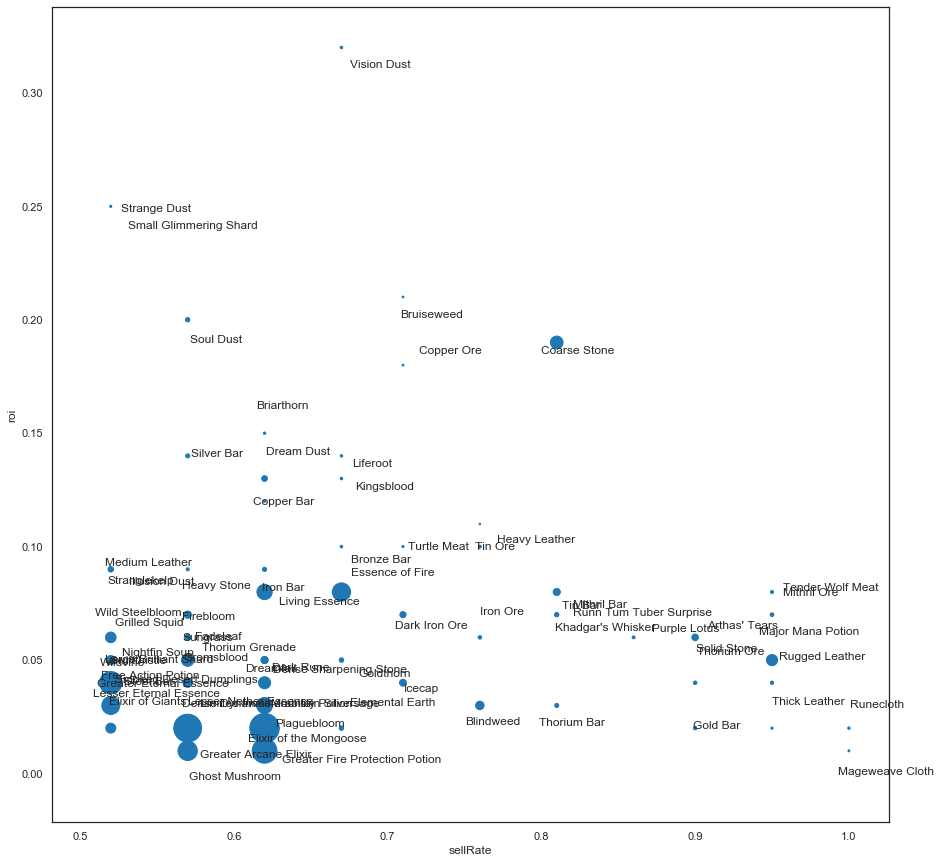

In [219]:
x = 'sellRate'
y = 'roi'
tmp = choice.query('roi < .7') # outlier
ax = tmp.plot(kind='scatter', x=x, y=y, s=choice['sellPrice'], figsize=(15,15))

jiggle = choice[y].mean() * .15

for _, r in tmp.iterrows():
    ax.text(r[x]+random.uniform(-jiggle,jiggle), r[y]+random.uniform(-jiggle,jiggle), r['name'])    

### Export

In [181]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [203]:
def get_export(df, max_buy_pct=.95):
    # max_buy_pct default at 95% due to 5% auction house cut
    e = df.copy()
    
    # format for export (note, 100x to scale integer copper)
    e['name'] = e.apply(lambda row: f"{int(100*row['sellRate'])}sr_{int(row['restock'])}stock_{row['name']}", axis=1)
    e['buy_price']    = 100 * e['sellPrice'] * max_buy_pct 
    e['min_price']    = 100 * e['sellPrice']
    e['normal_price'] = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
    e['max_price']    = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
    e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})
    
    # stack_size=10 if item price is less than 1g, else stack_size=5
    e['stack_size'] = e['sellPrice'].apply(lambda x: 20 if x < 100 else 5)
    
    EXPORT(e)
    return e
e = get_export(choice, .95)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^Ss52sr_45restock_Wildvine^T^SaboveMax^SmaxPrice^SnormalPrice^S13199^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N5^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S13199^SignoreLowDuration^N0^SstackSize^N1^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S12000^SkeepQtySources^T^t^Sblacklist^S^t^SS52sr_45restock_Wildvine^T^SaboveMax^SmaxPrice^SnormalPrice^S13198^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S13198^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S11999^SkeepQtySources^T^t^Sblacklist^S^t^Ss90sr_34restock_Arthas' Tears^T^SaboveMax^SmaxPrice^S

### Inspect Results

In [16]:
t = choice.copy()
t['median'] = t['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].median())
t['pctOfMedian'] = t['sellPrice'] / t['median']
t['stdNorm'] = t['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].std()) / t['sellPrice']
t.sort_values(by='pctOfMedian').tail(5)

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi,quantity,median,pctOfMedian,stdNorm
16,3821,Goldthorn,21.70,0.43,1.20,20.62,17.75,0.76,2.75,0.33,1.18,0.06,160,19.230,1.128445,0.628206
159,5634,Free Action Potion,127.49,0.43,0.60,121.12,103.27,0.63,23.62,0.27,10.12,0.10,242,109.995,1.159053,0.151399
1,8836,Arthas' Tears,5.75,0.50,0.57,5.46,4.36,0.68,0.82,0.34,0.41,0.08,104,4.840,1.188017,3.284823
71,16204,Illusion Dust,14.00,0.50,0.00,13.30,9.87,0.66,4.13,0.33,2.06,0.21,1625,10.740,1.303538,0.301034
237,10286,Heart of the Wild,7.84,0.50,2.40,7.45,4.98,0.70,0.46,0.35,0.23,0.03,128,5.640,1.390071,1.378422


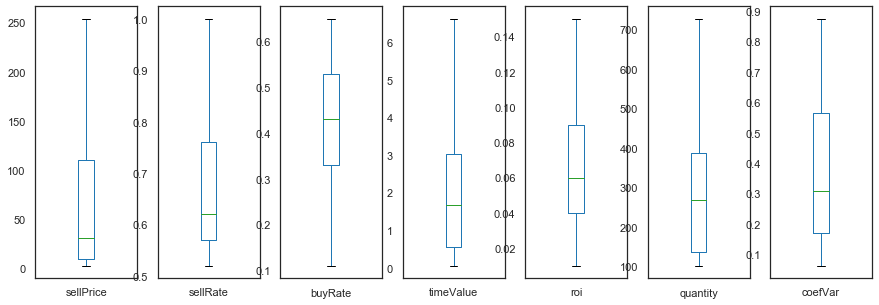

In [200]:
# sellPrice	sellRate	postCost	maxBuy	meanBuy	buyRate	value	flipRate	timeValue	roi	quantity	restock

# import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=7)

choice.plot(kind='box', y='sellPrice', showfliers=False, ax=axes[0])
choice.plot(kind='box', y='sellRate', showfliers=False, ax=axes[1])
choice.plot(kind='box', y='buyRate', showfliers=False, ax=axes[2])
choice.plot(kind='box', y='timeValue', showfliers=False, ax=axes[3])
choice.plot(kind='box', y='roi', showfliers=False, ax=axes[4])
choice.plot(kind='box', y='quantity', showfliers=False, ax=axes[5])
choice.plot(kind='box', y='coefVar', showfliers=False, ax=axes[6])


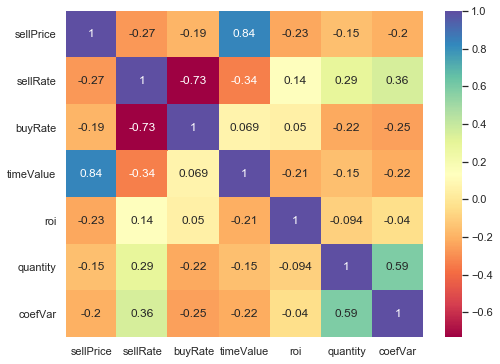

In [202]:
tcorr = choice[['sellPrice','sellRate','buyRate','timeValue','roi','quantity','coefVar']].corr()
sns.heatmap(tcorr, xticklabels=tcorr.columns, yticklabels=tcorr.columns, annot=True, cmap="Spectral")